# Synopsis

Applying Syuzhet methods to *Dracula* using NRC, Bing, Syuzhet, and VADER.

# Configuration

In [15]:
pwd = '/Users/rca2t/COURSES/DSI/DS5559/UVA_DSI_REPO/labs/2019-04-11_Lab11/'

# Developed in other notebook
lex_db = './lexicons.db'

# Developed in previous lab
text_db = '../../data/novels.db'
OHCO = ['genre', 'author', 'book', 'chapter', 'para_num', 'sent_num']
CHAPS = OHCO[:4]
PARAS = OHCO[:5]
SENTS = OHCO[:6]

novel = 'dracula'

# emo = 'bing_sentiment'
emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

# Libraries

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import sys
import scipy.fftpack as fftpack
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale

import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

# Pragmas

In [3]:
%cd {pwd}
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

/Users/rca2t/Dropbox/Courses/DSI/DS5559/UVA_DSI_REPO/labs/2019-04-11_Lab11


# Process

## Get Lexicons

In [4]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [5]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


### Get lexicon columns

In [6]:
# emo_cols = [col for col in combo.columns if 'nrc_' in col]
emo_cols = combo.columns

In [7]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'syu_sentiment', 'gi_sentiment'],
      dtype='object')

## Get Text

In [17]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE book = '{}' AND punc = 0".format(novel), db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

### Merge sentiment lexicon with vocab

In [18]:
tokens = tokens.join(combo, on='term_str', how='left')

In [19]:
tokens

token_num  pos  \
genre author book    chapter para_num sent_num                   
g     stoker dracula 1       0        0                 0  NNP   
                                      0                 1  NNP   
                                      0                 2  NNP   
                             1        0                 0   NN   
                                      0                 1   IN   
                                      0                 2   NN   
                             2        0                 0   NN   
                                      0                 1  NNP   
                                      1                 0  NNP   
                                      1                 3  VBD   
                                      1                 4  NNP   
                                      1                 5   IN   
                                      1                 6   CD   
                                      1                 7  NNP   
                                      1                 8  NNP   
                                      1                 9   IN   
                                      1                10   CD   
                                      1                11  NNP   
                                      1                12  VBG   
                                      1                13   IN   
                                      1                14  NNP   
                                      1                15   JJ   
                                      1                16   JJ   
                                      1                17   NN   
                                      1                18   MD   
                                      1                19   VB   
                                      1                20  VBN   
                                      1                21   IN   
                                      1                22   CD   
                                      1                23   CC   
...                                                   ...  ...   
                     27      116      0                13   NN   
                                      0                14   IN   
                                      0                15   JJ   
                                      0                16   NN   
                                      0                17   CD   
                             117      0                 0  NNP   
                                      0                 1  NNP   
                                      0                 2  VBD   
                                      0                 3   CD   
                             118      0                 0   DT   
                                      0                 1   NN   
                                      0                 2   IN   
                                      0                 3  NNP   
                                      0                 4   DT   
                                      0                 5   NN   
                                      0                 6   IN   
                                      0                 7  NNP   
                                      0                 8    $   
                                      0                 9   CD   
                             119      0                 0   NN   
                                      0                 1   IN   
                                      0                 2   DT   
                                      0                 3  NNP   
                                      0                 4  NNP   
                                      0                 5  NNP   
                                      0                 6   IN   
                                      0                 7  NNP   
                                      0                 8   IN   
                      

In [20]:
tokens[emo].sample(10)

genre  author  book     chapter  para_num  sent_num
g      stoker  dracula  17       22        1           1.0
                        18       3         1           NaN
                        7        27        0           NaN
                        10       75        1           NaN
                        27       91        1           NaN
                        3        11        1           NaN
                        20       46        4           NaN
                        21       5         1           NaN
                        26       40        3           NaN
                        2        13        2           NaN
Name: syu_sentiment, dtype: float64

In [21]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [22]:
tokens.head(10)

token_num  pos     token_str  \
genre author book    chapter para_num sent_num                                 
g     stoker dracula 1       0        0                 0  NNP      JONATHAN   
                                      0                 1  NNP      HARKER'S   
                                      0                 2  NNP       JOURNAL   
                             1        0                 0   NN        (_Kept   
                                      0                 1   IN            in   
                                      0                 2   NN  shorthand._)   
                             2        0                 0   NN            _3   
                                      0                 1  NNP          May.   
                                      1                 0  NNP    Bistritz._   
                                      1                 3  VBD          Left   

                                                punc  num   term_str  term_id  \
genre author book    chapter para_num sent_num                                  
g     stoker dracula 1       0        0            0    0   jonathan    13326   
                                      0            0    0    harkers    11163   
                                      0            0    0    journal    13342   
                             1        0            0    0       kept    13470   
                                      0            0    0         in    12267   
                                      0            0    0  shorthand    21649   
                             2        0            0    1       None       -1   
                                      0            0    0        may    14916   
                                      1            0    0   bistritz     2412   
                                      1            0    0       left    13914   

                                                nrc_anger  nrc_anticipation  \
genre author book    chapter para_num sent_num                                
g     stoker dracula 1       0        0               0.0               0.0   
                                      0               0.0               0.0   
                                      0               0.0               0.0   
                             1        0               0.0               0.0   
                                      0               0.0               0.0   
                                      0               0.0               0.0   
                             2        0               0.0               0.0   
                                      0               0.0               0.0   
                                      1               0.0               0.0   
                                      1               0.0               0.0   

                                                nrc_disgust      ...       \
genre author book    chapter para_num sent_num                   ...        
g     stoker dracula 1       0        0                 0.0      ...        
                                      0                 0.0      ...        
                                      0                 0.0      ...        
                             1        0                 0.0      ...        
                                      0                 0.0      ...        
                                      0                 0.0      ...        
                             2        0                 0.0      ...        
                                      0                 0.0      ...        
                                      1                 0.0      ...        
                                      1                 0.0      ...        

                                                nrc_negative  nrc_positive  \
genre author book    chapter para_num sent_num                               
g     stoker dracula 1       0        0                  0.0           0.0   
      

## Sentiment by OHCO

In [23]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)

### By Chapter

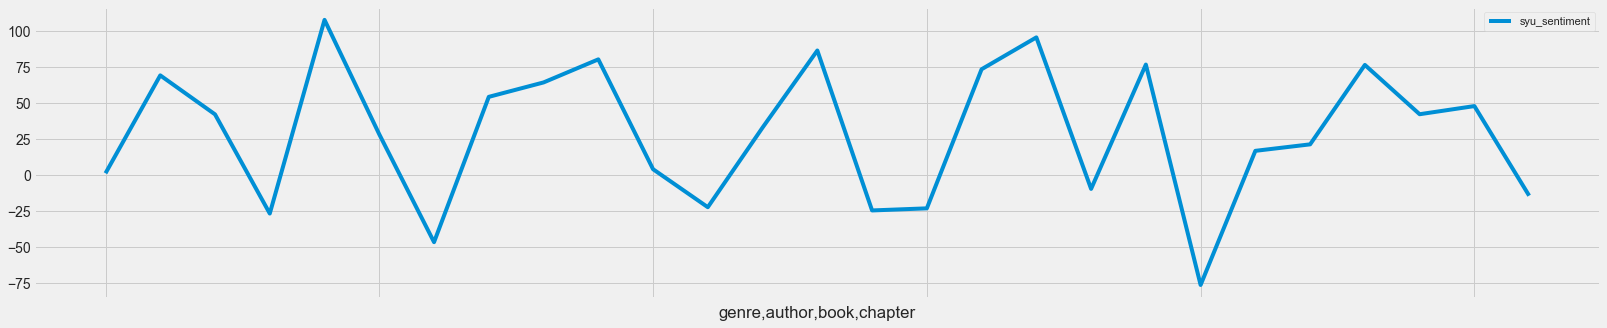

In [24]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

### By Paragraph

In [25]:
by_para = tokens.groupby(PARAS)[emo_cols].sum()

In [26]:
max_x = by_para.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)

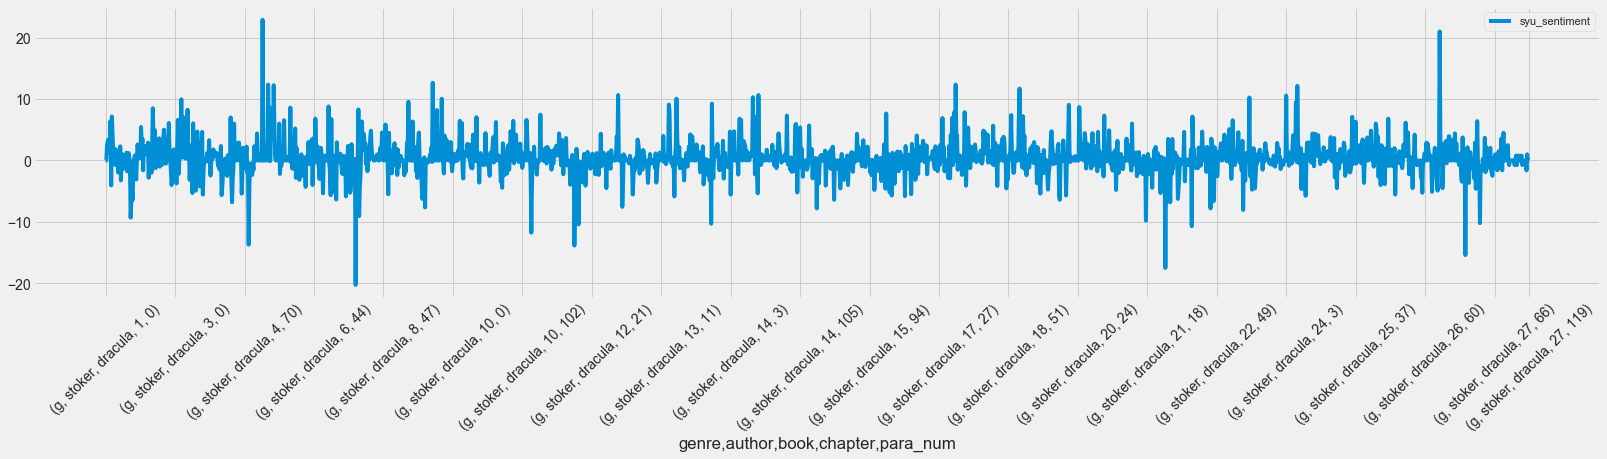

In [27]:
by_para[emo].plot(**FIG, xticks=xticks)

### By Sentence

In [28]:
by_sent = tokens.groupby(SENTS)[emo_cols].sum()

In [29]:
max_x = by_sent.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)

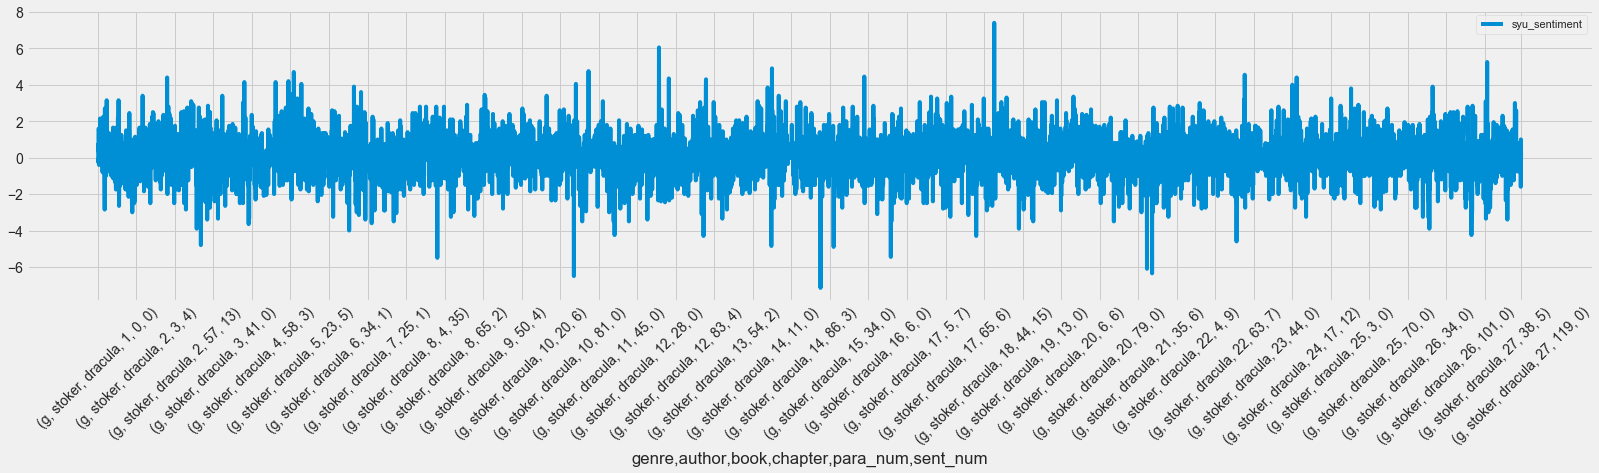

In [30]:
by_sent[emo].plot(**FIG, xticks=xticks)

### Add text to do spot checks

In [31]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [32]:
tokens['html'].head()

genre  author  book     chapter  para_num  sent_num
g      stoker  dracula  1        0         0           <span class='sent0'>JONATHAN</span>
                                           0           <span class='sent0'>HARKER'S</span>
                                           0            <span class='sent0'>JOURNAL</span>
                                 1         0             <span class='sent0'>(_Kept</span>
                                           0                 <span class='sent0'>in</span>
Name: html, dtype: object

In [33]:
by_sent['sent_str'] = tokens.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_sent['html_str'] = tokens.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [34]:
by_sent[['sent_str', 'html_str']].head()

sent_str  \
genre author book    chapter para_num sent_num                                                      
g     stoker dracula 1       0        0                                  jonathan harkers journal   
                             1        0                                         kept in shorthand   
                             2        0                                                       may   
                                      1         bistritz left munich at p m on may arriving at...   
                                      2         buda pesth seems a wonderful place from the gl...   

                                                                                         html_str  
genre author book    chapter para_num sent_num                                                     
g     stoker dracula 1       0        0         <span class='sent0'>JONATHAN</span> <span clas...  
                             1        0         <span class='sent0'>(_Kept</span> <span class=...  
                             2        0         <span class='sent0'>_3</span> <span class='sen...  
                                      1         <span class='sent0'>Bistritz._</span> <span cl...  
                                      2         <span class='sent0'>Buda</span> <span class='s...

### Histogram

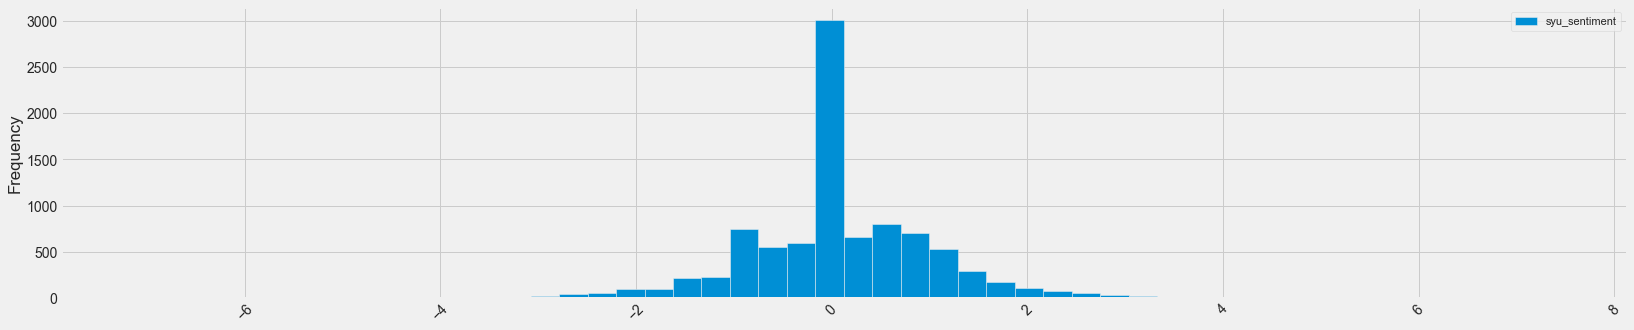

In [35]:
by_sent[emo].plot.hist(**FIG, bins=50)

### Look at a sample of sentences

In [36]:
rows = []
for idx in by_sent.sample(10).index:
    
    valence = round(by_sent.loc[idx, emo], 4)     
    t = 0
    if valence > t: color = '#ccffcc'
    elif valence < t: color = '#ffcccc'
    else: color = '#f2f2f2'
    z=0
    rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
    <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
    </tr>""".format(color, valence, by_sent.loc[idx, 'html_str'], idx))
    
display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

Sentiment,ID,Sentence
0.0,"('g', 'stoker', 'dracula', 3, 27, 1)","I did not see the face, but I knew the man by the neck and the movement of his back and arms."
0.0,"('g', 'stoker', 'dracula', 25, 17, 2)","You are nearest and dearest and all the world to me; our souls are knit into one, for all life and all time."
-0.75,"('g', 'stoker', 'dracula', 25, 48, 0)",Van Helsing and I were a little alarmed about Mrs. Harker to day.
1.0,"('g', 'stoker', 'dracula', 26, 30, 4)","I sent them aboot their business pretty quick; but as just after a fog closed in on us I felt a wee bit as they did anent something, though I wouldn't say it was agin the big box."
0.8,"('g', 'stoker', 'dracula', 1, 28, 2)","He will now come on to Bukovina, and return to morrow or the next day; better the next day."""
1.1,"('g', 'stoker', 'dracula', 18, 50, 3)","You used to laugh at me for it then, Art."""
0.4,"('g', 'stoker', 'dracula', 19, 5, 8)","The Professor stepped over, and laying his hand on his shoulder, said in his grave, kindly way:"
-0.75,"('g', 'stoker', 'dracula', 21, 51, 0)","""Nonsense, Mina."
0.0,"('g', 'stoker', 'dracula', 10, 15, 8)","The instant we had closed the door he stepped quickly along the passage to the next door, which was open."
0.0,"('g', 'stoker', 'dracula', 1, 21, 1)","They were evidently talking of me, for every now and then they looked at me, and some of the people who were sitting on the bench outside the door which they call by a name meaning ""word bearer"" came and listened, and then looked at me, most of them pityingly."


### Plot with Xticks

In [37]:
xticks = [0]
xticks += by_sent[emo].reset_index().sort_values(emo).head(7).index.values.tolist()
xticks += by_sent[emo].reset_index().sort_values(emo).tail(7).index.values.tolist()
xticks += [by_sent.shape[0] - 1]

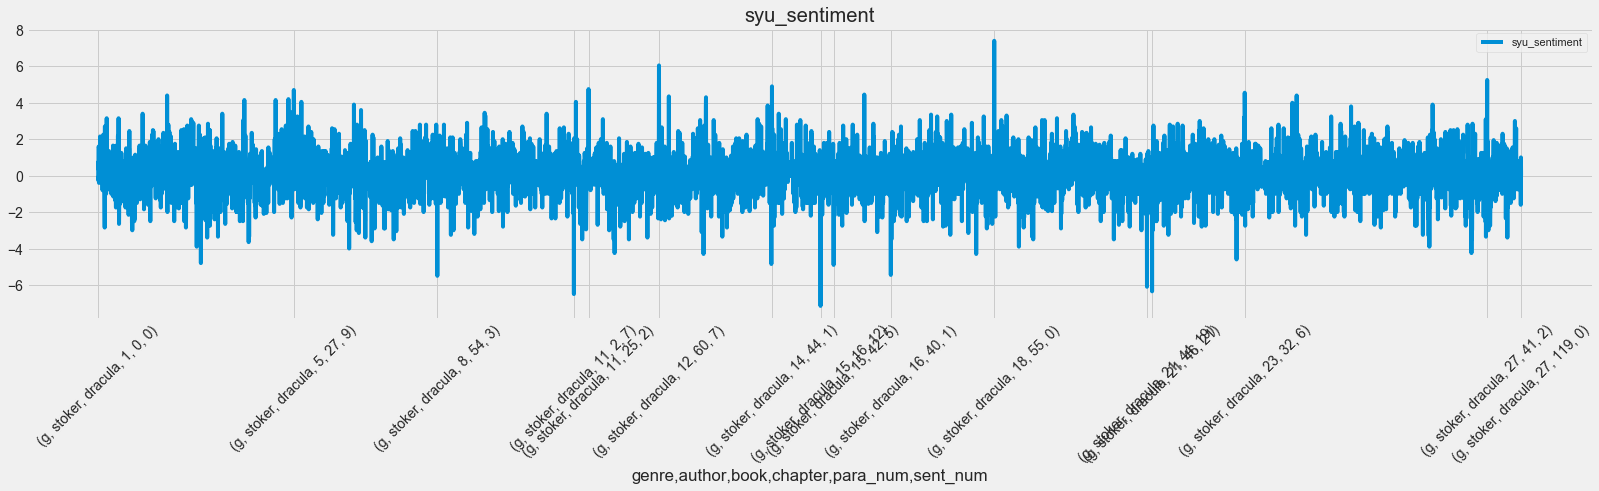

In [38]:
by_sent[emo].plot(**FIG, xticks=xticks, title=emo)

In [39]:
by_sent.iloc[xticks][emo].sort_index().to_frame()

syu_sentiment
genre author book    chapter para_num sent_num               
g     stoker dracula 1       0        0                  0.00
                     5       27       9                  4.70
                     8       54       3                 -5.50
                     11      2        7                 -6.50
                             25       2                  4.75
                     12      60       7                  6.05
                     14      44       1                  4.90
                     15      16       12                -7.15
                             42       5                 -4.90
                     16      40       1                 -5.45
                     18      55       0                  7.40
                     21      44       19                -6.10
                             46       21                -6.35
                     23      32       6                  4.55
                     27      41       2                  5.25
                             119      0                  0.00

### Inspect Positives

In [40]:
by_sent.sort_values(emo, ascending=False)[[emo,'sent_str']].head(20)

syu_sentiment  \
genre author book    chapter para_num sent_num                  
g     stoker dracula 18      55       0                  7.40   
                     12      60       7                  6.05   
                     27      41       2                  5.25   
                     14      44       1                  4.90   
                     11      25       2                  4.75   
                     5       27       9                  4.70   
                     23      32       6                  4.55   
                     15      104      5                  4.45   
                     2       50       5                  4.40   
                     24      19       15                 4.40   
                     12      76       10                 4.35   
                     13      35       0                  4.30   
                     5       21       10                 4.20   
                     4       49       6                  4.15   
                     5       11       10                 4.15   
                     11      5        2                  4.05   
                     5       42       6                  4.05   
                     24      17       12                 4.00   
                     26      82       4                  3.90   
                     7       5        8                  3.90   

                                                                                         sent_str  
genre author book    chapter para_num sent_num                                                     
g     stoker dracula 18      55       0         all the men even jonathan seemed relieved but ...  
                     12      60       7         jonathan asks me to send his respectful duty b...  
                     27      41       2         she was so fair to look on so radiantly beauti...  
                     14      44       1         believe me then that i come here full of respe...  
                     11      25       2         thomas and his wife are hospitable folk elderl...  
                     5       27       9         you can you know if you like for that other go...  
                     23      32       6         oh that i could give any idea of the scene of ...  
                     15      104      5         i have come here from my own land to do what i...  
                     2       50       5         i seek not gaiety nor mirth not the bright vol...  
                     24      19       15        he learn new social life new environment of ol...  
                     12      76       10        oh it is too hard that a sweet simple noble st...  
                     13      35       0         he was a good fellow but his rejoicing at the ...  
                     5       21       10        i must tell you beforehand that mr morris does...  
                     4       49       6         i knew pretty well the direction and distance ...  
                     5       11       10        he is an excellent parti being handsome well o...  
                     11      5        2         it was a lovely morning the bright sunshine an...  
                     5       42       6         we promise you a hearty welcome and a loving g...  
                     24      17       12        in him some vital principle have in strange wa...  
                     26      82       4         i felt so thankful that lord godalming is rich...  
                     7       5        8         the approach of sunset was so very beautiful s...

### Inspect Negatives

In [41]:
by_sent.sort_values(emo, ascending=True)[[emo,'sent_str']].head(20)

syu_sentiment  \
genre author book    chapter para_num sent_num                  
g     stoker dracula 15      16       12                -7.15   
                     11      2        7                 -6.50   
                     21      46       21                -6.35   
                             44       19                -6.10   
                     8       54       3                 -5.50   
                     16      40       1                 -5.45   
                     15      42       5                 -4.90   
                     14      43       2                 -4.85   
                     3       28       1                 -4.80   
                     23      23       14                -4.60   
                     18      35       12                -4.30   
                     13      31       0                 -4.30   
                     11      75       2                 -4.25   
                     27      24       5                 -4.25   
                     6       61       11                -4.00   
                     3       23       5                 -3.90   
                     26      78       1                 -3.90   
                     19      8        5                 -3.90   
                     4       51       6                 -3.65   
                     7       35       3                 -3.60   

                                                                                         sent_str  
genre author book    chapter para_num sent_num                                                     
g     stoker dracula 15      16       12        the tomb in the day time and when wreathed wit...  
                     11      2        7         oh the terrible struggle that i have had again...  
                     21      46       21        his wife through her terror and horror and dis...  
                             44       19        then she put before her face her poor crushed ...  
                     8       54       3         he has had some fearful shock so says our doct...  
                     16      40       1         when they become such there comes with the cha...  
                     15      42       5         outrageous as it was to open a leaden coffin t...  
                     14      43       2         the pity for jonathan the horror which he expe...  
                     3       28       1         i feel the dread of this horrible place overpo...  
                     23      23       14        it would be impossible to describe the express...  
                     18      35       12        this vampire which is amongst us is of himself...  
                     13      31       0         because i get it back from the worthless wretc...  
                     11      75       2         i was dazed and stupid with pain and terror an...  
                     27      24       5         all was in dead grim silence only that the hor...  
                     6       61       11        maybe its in that wind out over the sea thats ...  
                     3       23       5         i quite understood my only doubt was as to whe...  
                     26      78       1         have you seen that awful den of hellish infamy...  
                     19      8        5         keep this near your heart as he spoke he lifte...  
                     4       51       6         i thought he might have the keys on him but wh...  
                     7       35       3         he was in a panic of superstitious fear and i ...

## Apply Transforms

### Adapt Jockers' original FFT function 

Fast Fourier Transform. See https://rdrr.io/cran/syuzhet/man/get_transformed_values.html

In [42]:
def get_transformed_values(raw_values, low_pass_size = 2, x_reverse_len = 100,  padding_factor = 2, scale_values = False, scale_range = False):

    if low_pass_size > len(raw_values):
        sys.exit("low_pass_size must be less than or equal to the length of raw_values input vector")

    raw_values_len = len(raw_values)
    padding_len = raw_values_len * padding_factor

    # Add padding, then fft
    values_fft = fftpack.fft(raw_values, padding_len)
    low_pass_size = low_pass_size * (1 + padding_factor)
    keepers = values_fft[:low_pass_size]

    # Preserve frequency domain structure
    modified_spectrum = list(keepers) \
        + list(np.zeros((x_reverse_len * (1+padding_factor)) - (2*low_pass_size) + 1)) \
        + list(reversed(np.conj(keepers[1:(len(keepers))])))
    
    
    # Strip padding
    inverse_values = fftpack.ifft(modified_spectrum)
    inverse_values = inverse_values[:x_reverse_len]

#     transformed_values = np.real(tuple(inverse_values))
    transformed_values = np.real(inverse_values)
    return transformed_values

In [43]:
FFTCFG = dict(
    low_pass_size = 3,
    x_reverse_len = 100,
    padding_factor = 2
)
X = get_transformed_values(by_sent[emo].values, **FFTCFG)

/Users/rca2t/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


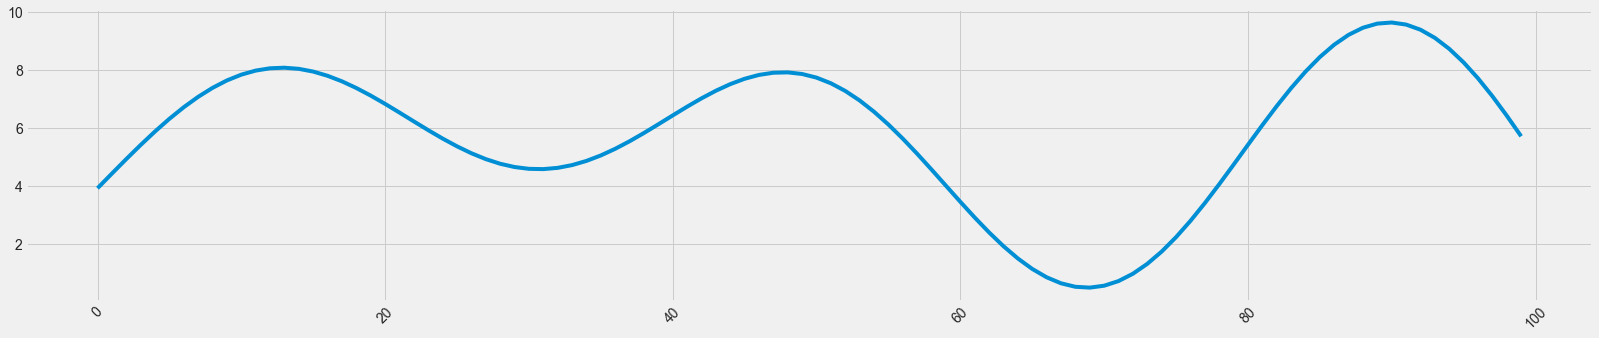

In [44]:
FIG['legend'] = False
pd.Series(X).plot(**FIG)

### Adapt Jockers' revised DCT function

Discrete Cosine Transform. A DCT is a Fourier-related transform similar to the discrete Fourier transform (DFT), but using only real numbers. 

In [45]:
def get_dct_transform(raw_values, low_pass_size = 5, x_reverse_len = 100):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = 2)
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return(dct_out)

In [46]:
FFTCFG1 = dict(
    low_pass_size = 5,
    x_reverse_len = 100
)
X1 = get_dct_transform(by_sent[emo].values, **FFTCFG1)

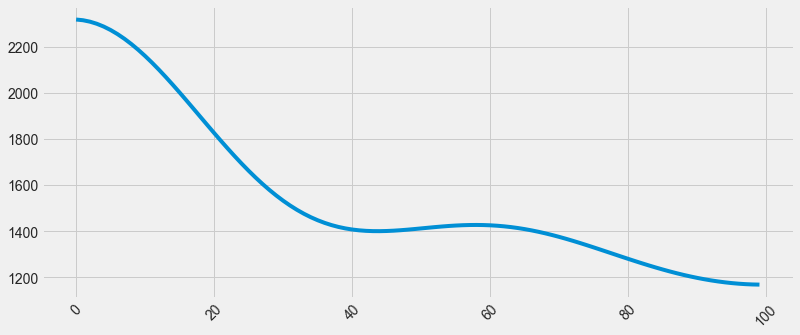

In [47]:
FIG['figsize'] = (12,5)
pd.Series(X1).plot(**FIG)

### Using Rolling
**Window types**: 
boxcar
triang
blackman
hamming
bartlett
parzen
bohman
blackmanharris
nuttall
barthann
kaiser (needs beta)
gaussian (needs std)
general_gaussian (needs power, width)
slepian (needs width).

In [73]:
# Config for sentences
CFG1 = dict(
    win_type='blackman',
    window=5000,
    center=True
)

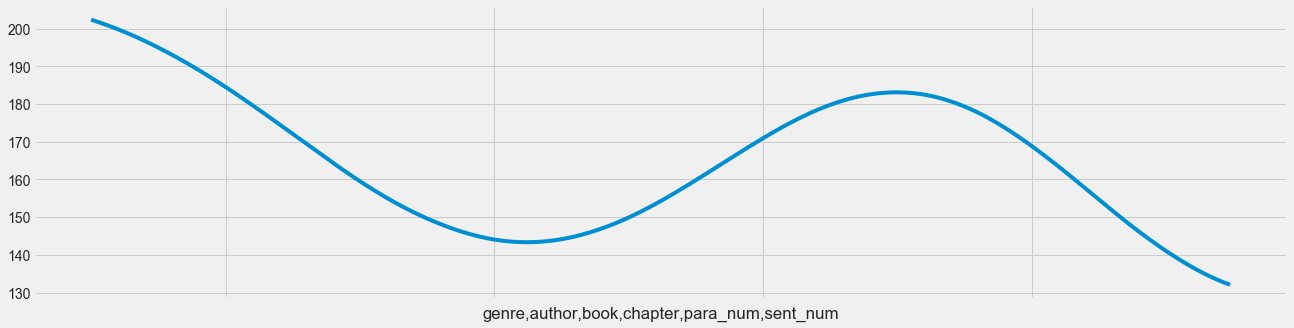

In [62]:
FIG['figsize'] = (20,5)
by_sent[emo].fillna(0).rolling(**CFG1).sum().plot(**FIG)

In [69]:
# Config for tokens
CFG2 = dict(
    win_type='blackman',
    window= int(tokens.shape[0]/ 3),
    center=True
)
CFG2['window']

54103

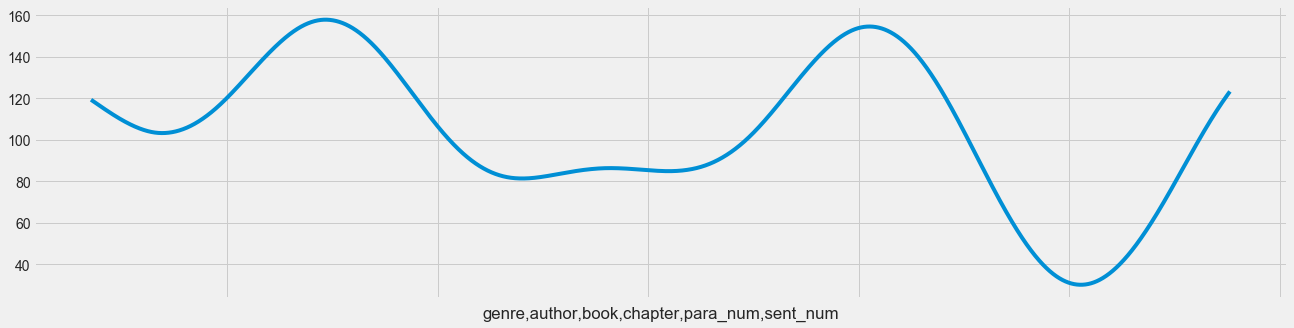

In [70]:
tokens[emo].fillna(0).rolling(**CFG2).sum().plot(**FIG)

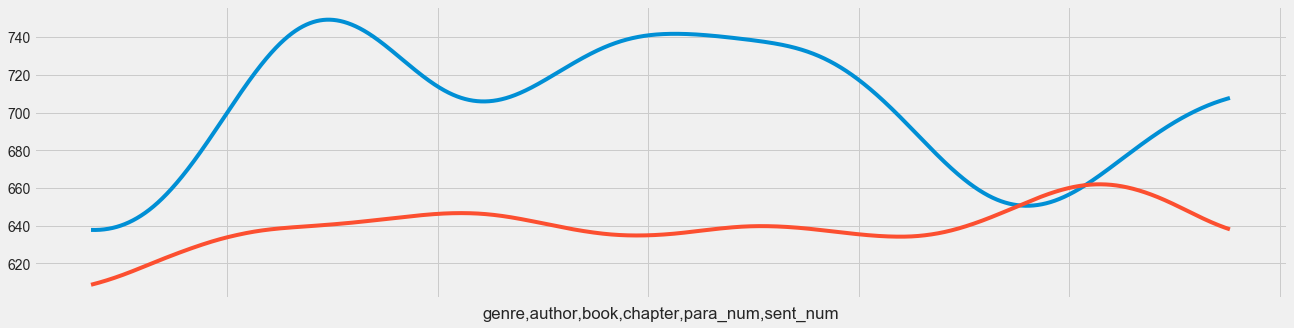

In [71]:
tokens[['nrc_positive','nrc_negative']].rolling(**CFG2).sum().plot(**FIG)

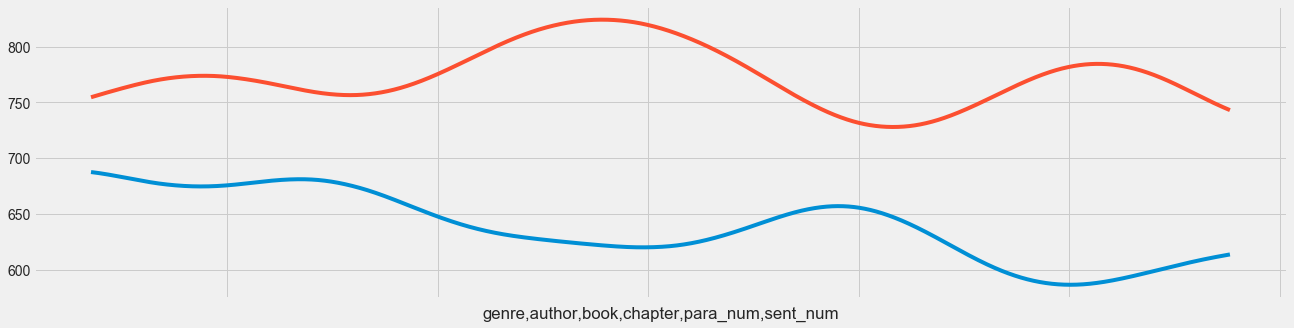

In [72]:
tokens[['bing_positive','bing_negative']].fillna(0).rolling(**CFG2).sum().plot(**FIG)

## Multinomial Emotions

In [54]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [55]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


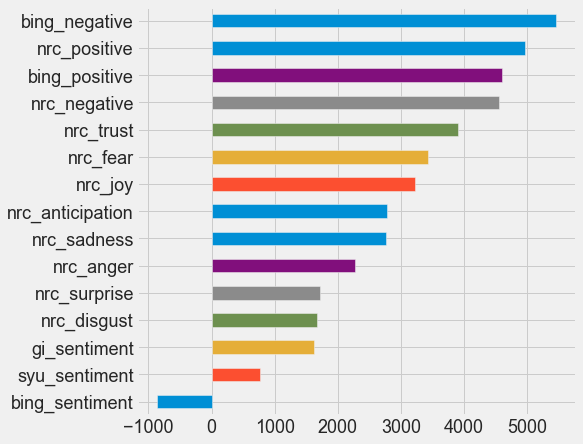

In [56]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18)

### Shape data for Sklearn's KDE function

In [48]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [49]:
B

,x
emo,
nrc_anger,"[[52], [71], [78], [91], [203], [381], [572], ..."
nrc_anticipation,"[[48], [210], [381], [415], [426], [434], [454..."
nrc_disgust,"[[71], [91], [412], [572], [593], [601], [704]..."
nrc_fear,"[[38], [71], [78], [91], [210], [381], [528], ..."
nrc_joy,"[[17], [28], [46], [48], [78], [130], [210], [..."
nrc_negative,"[[38], [52], [60], [71], [78], [91], [203], [2..."
nrc_positive,"[[2], [17], [28], [46], [48], [78], [130], [18..."
nrc_sadness,"[[52], [60], [78], [91], [244], [430], [572], ..."
nrc_surprise,"[[381], [415], [458], [528], [664], [683], [70..."


### Get KDE for each emotion

In [50]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
# kde_bandwidth = 250
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

### Visualize KDE plots

In [51]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T

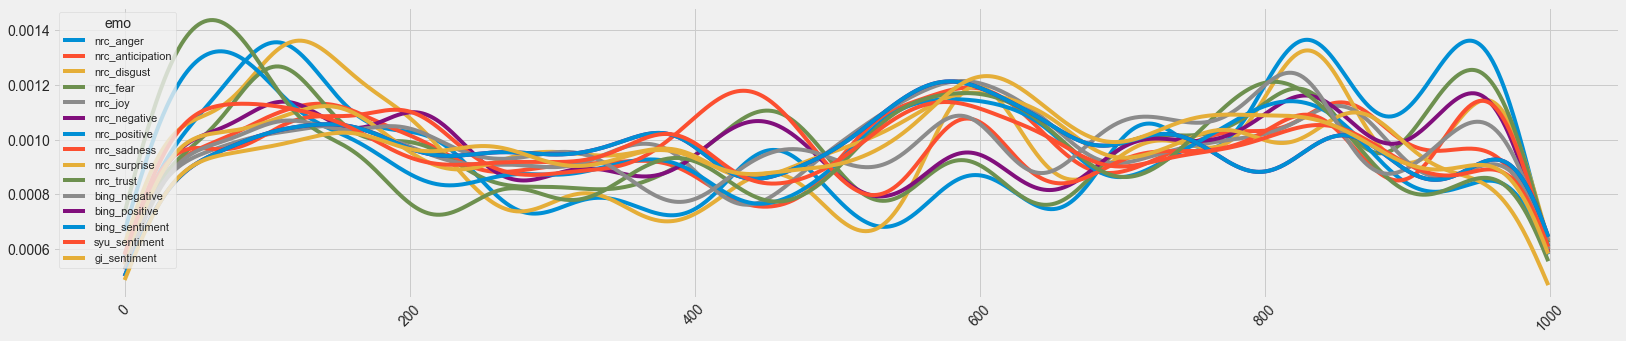

In [52]:
PLOTS.plot(**FIG)

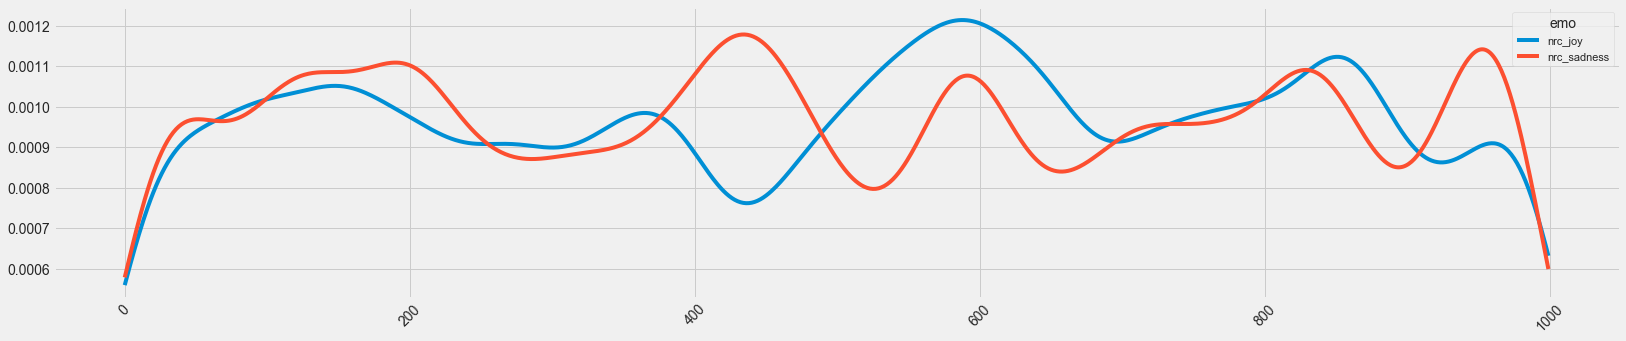

In [53]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

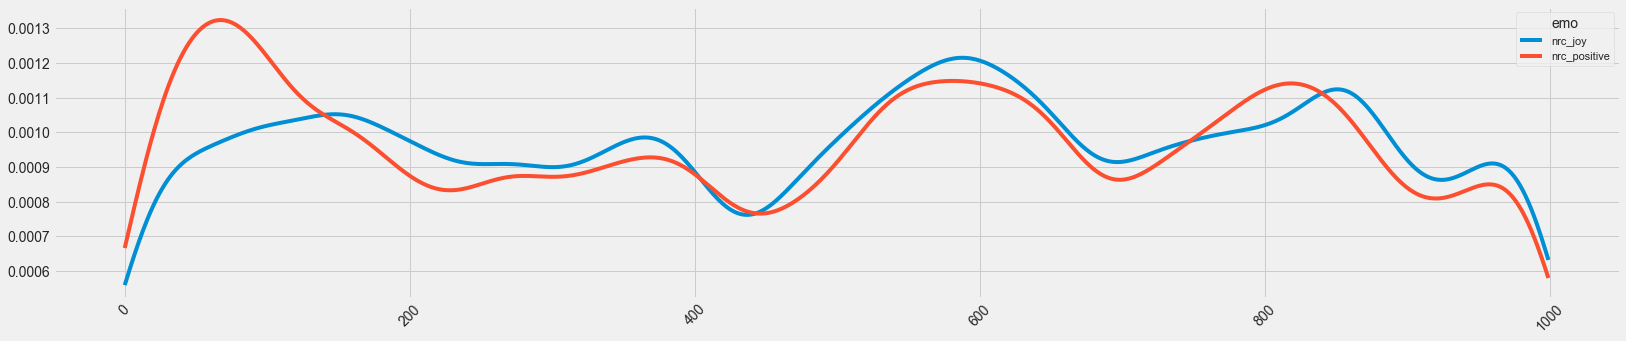

In [54]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

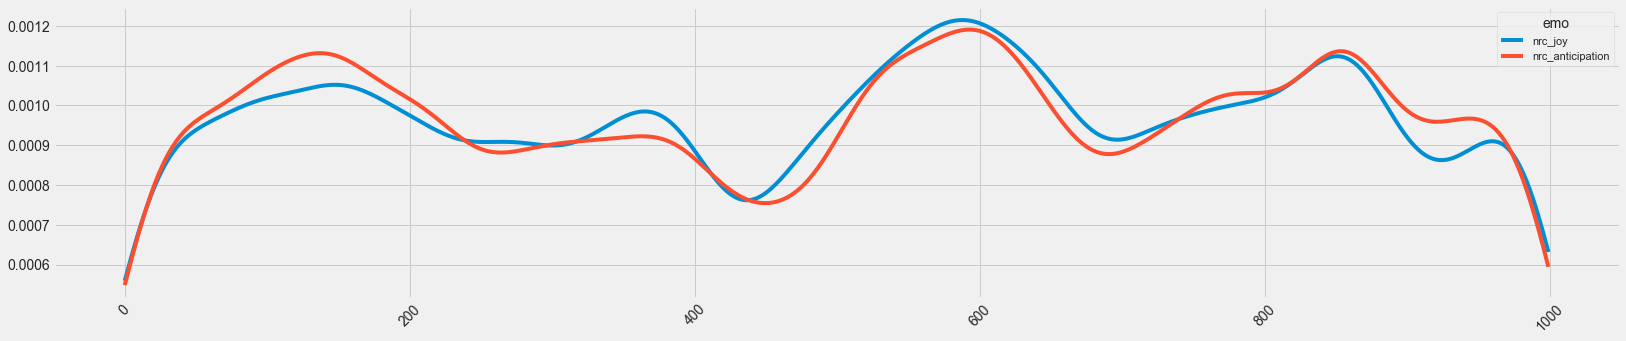

In [55]:
PLOTS[['nrc_joy','nrc_anticipation']].plot(**FIG)

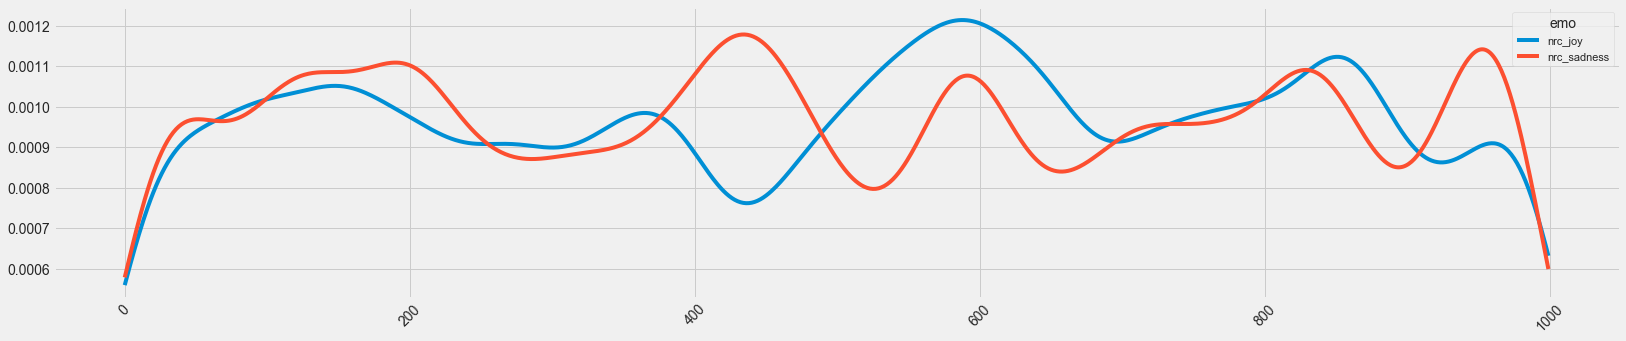

In [56]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

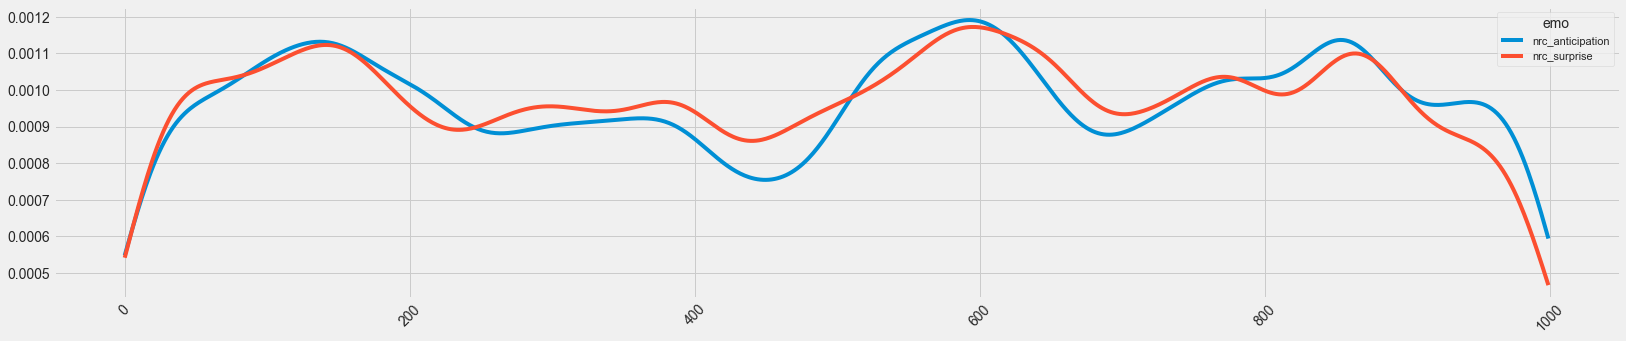

In [57]:
PLOTS[['nrc_anticipation','nrc_surprise']].plot(**FIG)

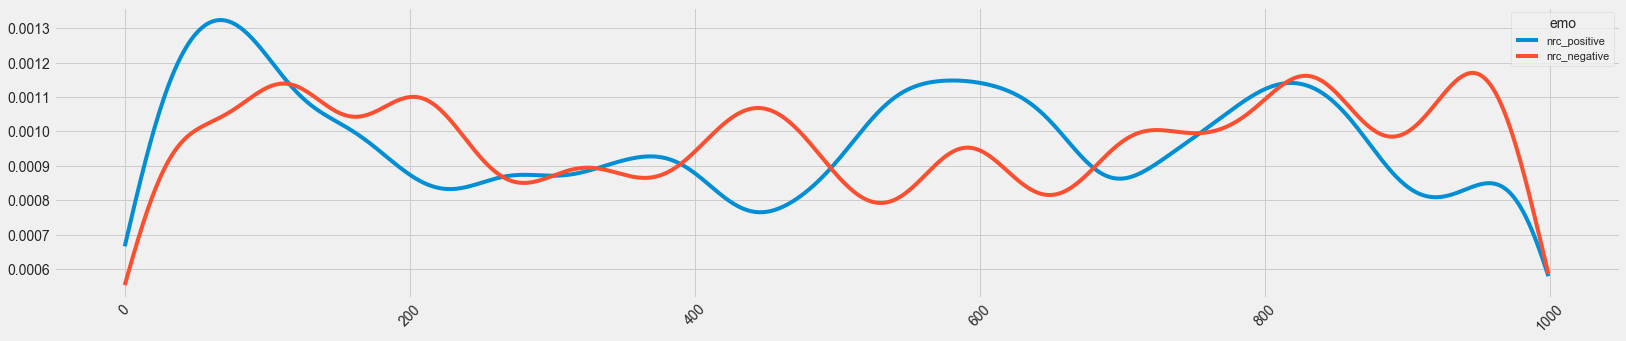

In [58]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

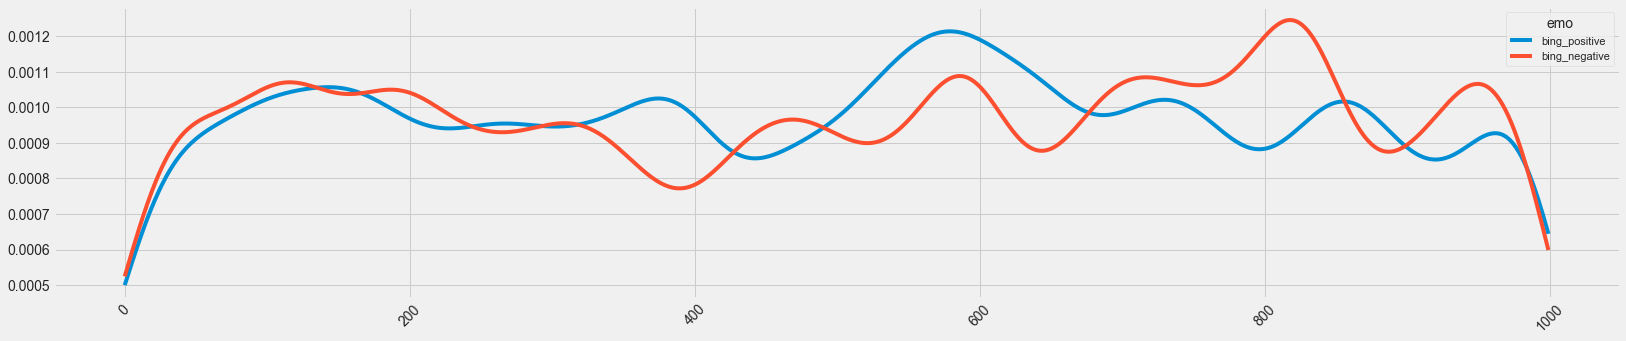

In [59]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)

### Compare KDE to Rolling graphs of Sentiment

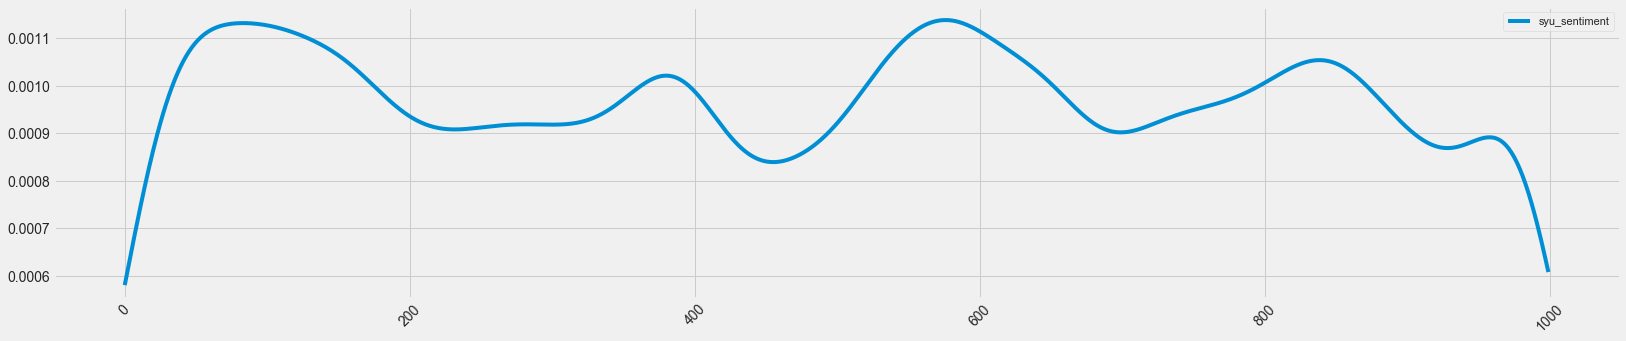

In [64]:
PLOTS[emo].plot(**FIG)

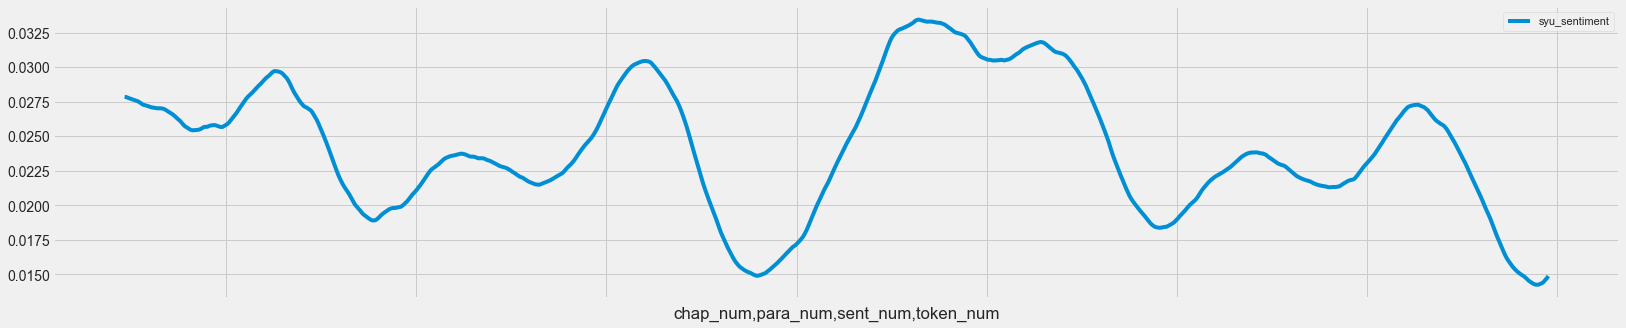

In [63]:
tokens[emo].fillna(0).rolling(**CFG2).mean().plot(**FIG)

In [ ]:
fig, axs = plt.subplots(len(emo_cols),2)
for i, emo in enumerate(emo_cols):
    FIGa = dict(figsize=(20,50), ax=axs[i,0], title=emo + ' (KDE)')
    FIGb = dict(figsize=(20,50), ax=axs[i,1], title=emo + ' (rolling)')
    PLOTS[emo].plot(**FIGa)
    tokens[emo].rolling(**CFG2).mean().plot(**FIGb)

## Peak Joy

### Find max joy from PLOTS

In [65]:
PLOTS.head()

emo,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.000569,0.000548,0.000618,0.000556,0.000559,0.000554,0.000666,0.000578,0.000542,0.000733,0.000524,0.000500,0.000500,0.000580,0.000486
1,0.000583,0.000562,0.000634,0.000570,0.000572,0.000568,0.000684,0.000593,0.000557,0.000753,0.000538,0.000513,0.000513,0.000596,0.000499
2,0.000598,0.000576,0.000650,0.000584,0.000586,0.000583,0.000702,0.000608,0.000572,0.000773,0.000552,0.000525,0.000525,0.000611,0.000512
3,0.000612,0.000590,0.000666,0.000597,0.000599,0.000597,0.000719,0.000622,0.000587,0.000792,0.000565,0.000538,0.000538,0.000626,0.000525
4,0.000626,0.000603,0.000682,0.000611,0.000612,0.000612,0.000737,0.000637,0.000602,0.000812,0.000579,0.000550,0.000550,0.000642,0.000538


In [66]:
PEAK_JOY = int((PLOTS['nrc_joy'].idxmax() / 1000) * tokens.shape[0])

In [67]:
PEAK_JOY_CHAP_NUM = tokens.iloc[PEAK_JOY].name[0]

In [68]:
PEAK_JOY_CHAP_NUM + 1

17

### Display Chapter

In [69]:
PEAK_JOY_CHAP = tokens.loc[PEAK_JOY_CHAP_NUM].groupby(['para_num']).token_str.apply(lambda x: ' '.join(x)).tolist()

In [70]:
display(HTML('<br/><br/>'.join(PEAK_JOY_CHAP)))

### Sparknotes' Synopsis

> One night, the Elliots receive an invitation to the Dalrymples' place, and Anne tells her family she must decline it because she has an engagement to visit Mrs. Smith. Sir Walter is horrified that Anne should be visiting such a poor neighborhood and is appalled that she chooses to associate with someone so much lower in consequence than herself.

https://www.sparknotes.com/lit/persuasion/section9/

## VADER

In [76]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [77]:
vader_cols = by_sent.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))

In [78]:
by_sent = pd.concat([by_sent, vader_cols], axis=1)

In [79]:
by_sent.head()

nrc_anger  nrc_anticipation  \
genre author book    chapter para_num sent_num                                
g     stoker dracula 1       0        0               0.0               0.0   
                             1        0               0.0               0.0   
                             2        0               0.0               0.0   
                                      1               0.0               0.0   
                                      2               0.0               0.0   

                                                nrc_disgust  nrc_fear  \
genre author book    chapter para_num sent_num                          
g     stoker dracula 1       0        0                 0.0       0.0   
                             1        0                 0.0       0.0   
                             2        0                 0.0       0.0   
                                      1                 0.0       0.0   
                                      2                 0.0       0.0   

                                                nrc_joy  nrc_negative  \
genre author book    chapter para_num sent_num                          
g     stoker dracula 1       0        0             0.0           0.0   
                             1        0             0.0           0.0   
                             2        0             0.0           0.0   
                                      1             0.0           1.0   
                                      2             1.0           0.0   

                                                nrc_positive  nrc_sadness  \
genre author book    chapter para_num sent_num                              
g     stoker dracula 1       0        0                  0.0          0.0   
                             1        0                  0.0          0.0   
                             2        0                  0.0          0.0   
                                      1                  0.0          1.0   
                                      2                  1.0          0.0   

                                                nrc_surprise  nrc_trust  \
genre author book    chapter para_num sent_num                            
g     stoker dracula 1       0        0                  0.0        0.0   
                             1        0                  0.0        0.0   
                             2        0                  0.0        0.0   
                                      1                  0.0        0.0   
                                      2                  1.0        1.0   

                                                  ...     bing_positive  \
genre author book    chapter para_num sent_num    ...                     
g     stoker dracula 1       0        0           ...               0.0   
                             1        0           ...               0.0   
                             2        0           ...               0.0   
                                      1           ...               0.0   
                                      2           ...               1.0   

                                                bing_sentiment  syu_sentiment  \
genre author book    chapter para_num sent_num                                  
g     stoker dracula 1       0        0                    0.0           0.00   
                             1        0                    0.0           0.00   
                             2        0                    0.0           0.00   
                                      1                    0.0          -0.25   
                                      2                    1.0           0.75   

                                                gi_sentiment  \
genre author book    chapter para_num sent_num                 
g     stoker dracula 1       0        0                  0.0   
                             1        0                  0.0   
                             2        0               

In [80]:
# See "anne could not help laughing"
by_sent.sort_values('neg', ascending=False).head(10)

nrc_anger  nrc_anticipation  \
genre author book    chapter para_num sent_num                                
g     stoker dracula 17      28       2               0.0               0.0   
                     14      99       8               0.0               0.0   
                             98       13              0.0               0.0   
                                      11              0.0               0.0   
                                      9               0.0               0.0   
                     24      19       6               0.0               0.0   
                     17      28       0               0.0               0.0   
                     24      7        0               0.0               0.0   
                     27      6        14              0.0               0.0   
                     14      32       4               0.0               0.0   

                                                nrc_disgust  nrc_fear  \
genre author book    chapter para_num sent_num                          
g     stoker dracula 17      28       2                 0.0       0.0   
                     14      99       8                 0.0       0.0   
                             98       13                0.0       0.0   
                                      11                0.0       0.0   
                                      9                 0.0       0.0   
                     24      19       6                 0.0       0.0   
                     17      28       0                 0.0       0.0   
                     24      7        0                 0.0       0.0   
                     27      6        14                0.0       0.0   
                     14      32       4                 0.0       0.0   

                                                nrc_joy  nrc_negative  \
genre author book    chapter para_num sent_num                          
g     stoker dracula 17      28       2             0.0           0.0   
                     14      99       8             0.0           0.0   
                             98       13            0.0           0.0   
                                      11            0.0           0.0   
                                      9             0.0           0.0   
                     24      19       6             0.0           0.0   
                     17      28       0             0.0           0.0   
                     24      7        0             0.0           0.0   
                     27      6        14            0.0           0.0   
                     14      32       4             0.0           0.0   

                                                nrc_positive  nrc_sadness  \
genre author book    chapter para_num sent_num                              
g     stoker dracula 17      28       2                  0.0          0.0   
                     14      99       8                  0.0          0.0   
                             98       13                 0.0          0.0   
                                      11                 0.0          0.0   
                                      9                  0.0          0.0   
                     24      19       6                  0.0          0.0   
                     17      28       0                  0.0          0.0   
                     24      7        0                  0.0          0.0   
                     27      6        14                 0.0          0.0   
                     14      32       4                  0.0          0.0   

                                                nrc_surprise  nrc_trust  \
genre author book    chapter para_num sent_num                            
g     stoker dracula 17      28       2                  0.0        0.0   
                     14      99       8                  0.0        0.0   
                             98       13                 0.0        0.0   
                                      11     

In [81]:
CFG1['window'] = 500

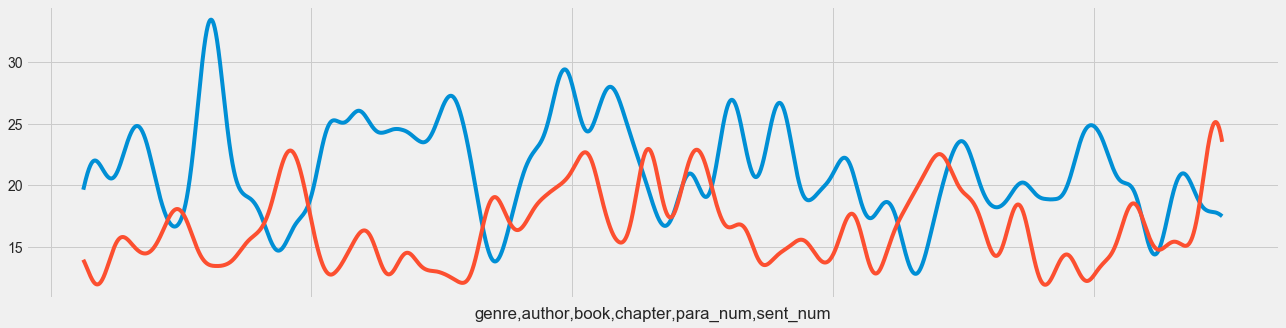

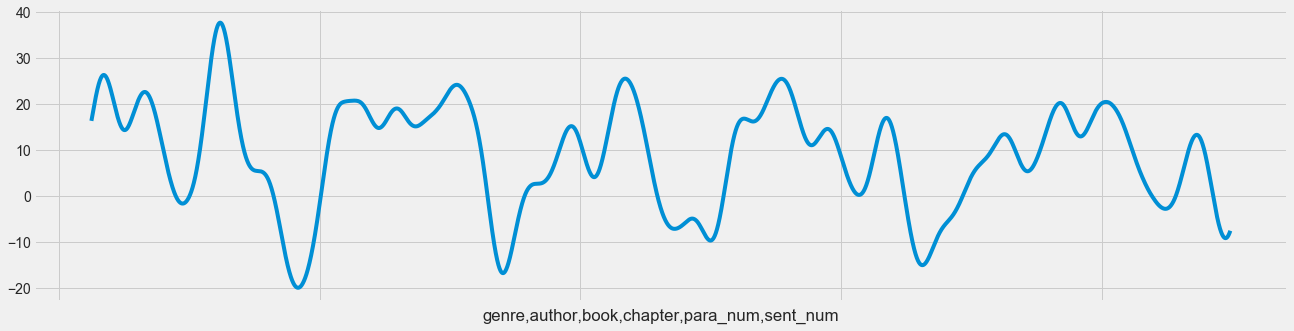

In [86]:
by_sent[['pos','neg']].rolling(**CFG1).sum().plot(**FIG)
by_sent[['compound']].rolling(**CFG1).sum().plot(**FIG)

## Compare KDE to Rolling Both Graphs of Syuzhet and VADER

In [87]:
PLOTS[emo].plot(**FIG)

NameError: name 'PLOTS' is not defined

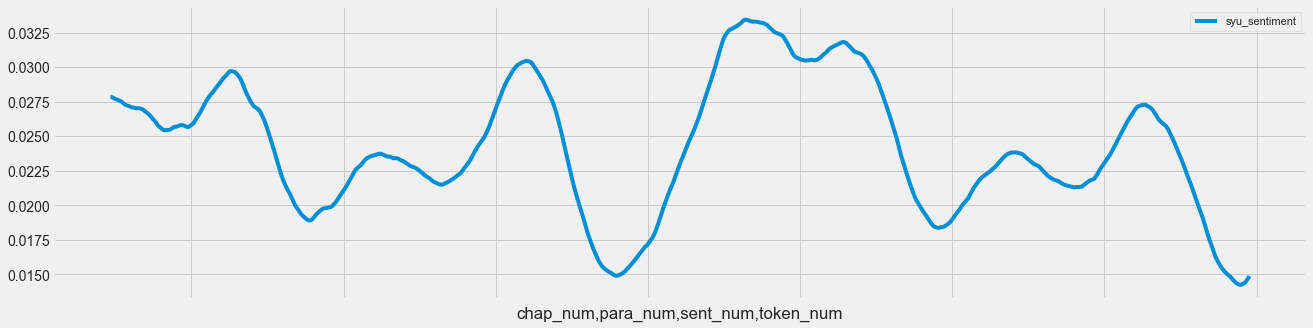

In [95]:
tokens[emo].fillna(0).rolling(**CFG2).mean().plot(**FIG)

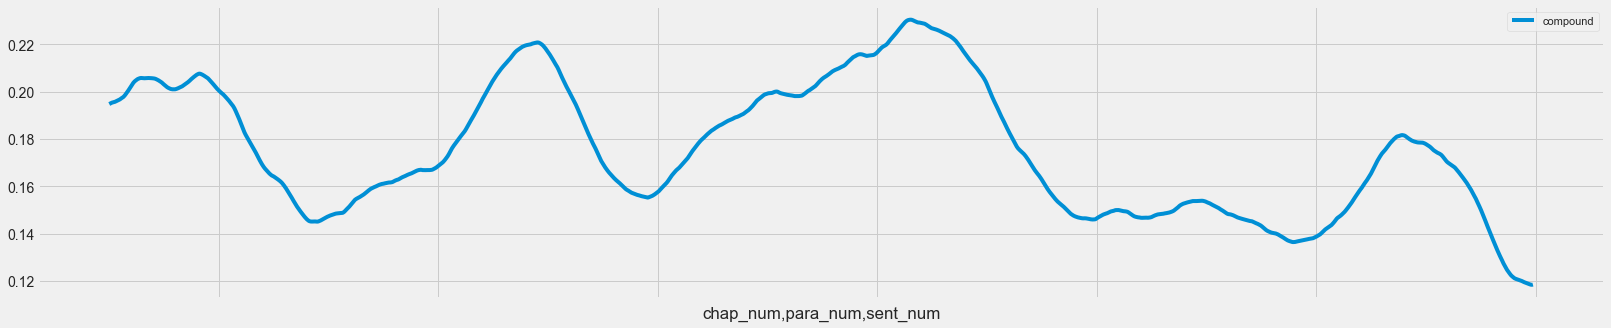

In [80]:
by_sent[['compound']].rolling(**CFG1).mean().plot(**FIG)

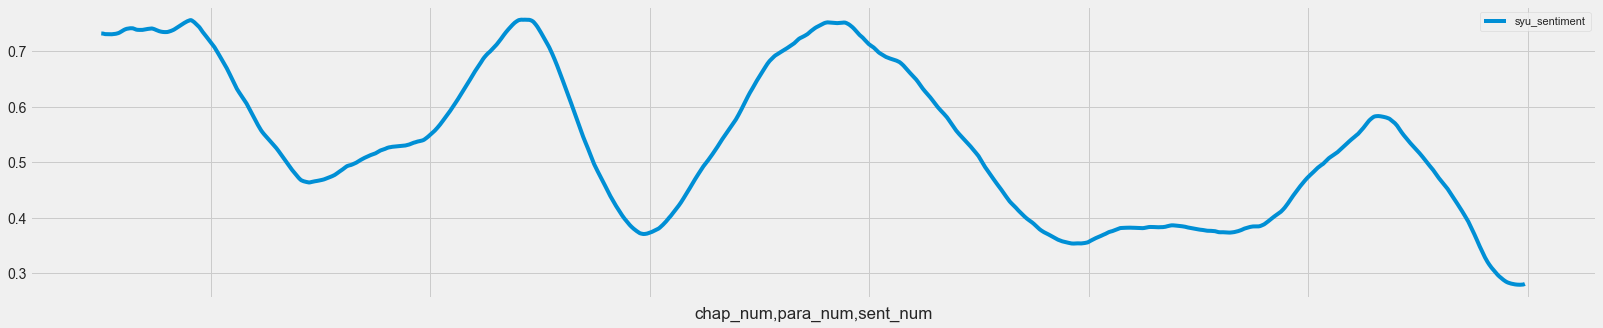

In [81]:
by_sent[emo].fillna(0).rolling(**CFG1).mean().plot(**FIG)

## Experimental Plotting Function

In [98]:
def  plot_sentiment(emo_col, type='sent'):
    if type == 'sent':
        by_sent[emo_col].fillna(0).rolling(**CFG1).mean().plot(**FIG)
    elif type == 'tokens':
        tokens[emo_col].fillna(0).rolling(**CFG2).mean().plot(**FIG)
    elif type == 'kde':
        PLOTS[emo_col].plot(**FIG)
    else:
        pass

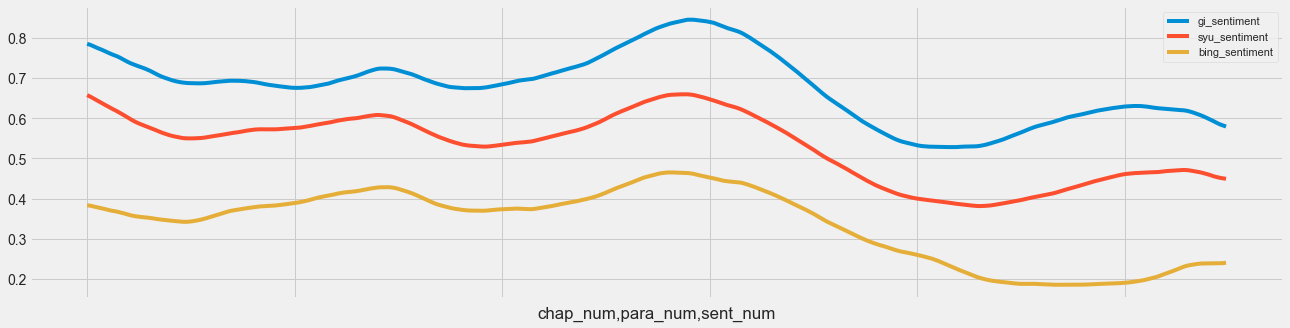

In [103]:
plot_sentiment('gi_sentiment')
plot_sentiment('syu_sentiment')
plot_sentiment('bing_sentiment')

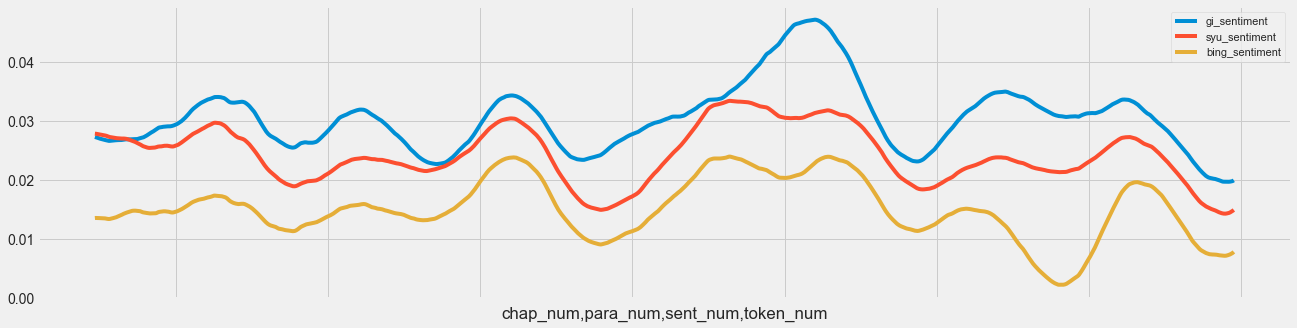

In [102]:
plot_sentiment('gi_sentiment', type='tokens')
plot_sentiment('syu_sentiment', type='tokens')
plot_sentiment('bing_sentiment', type='tokens')

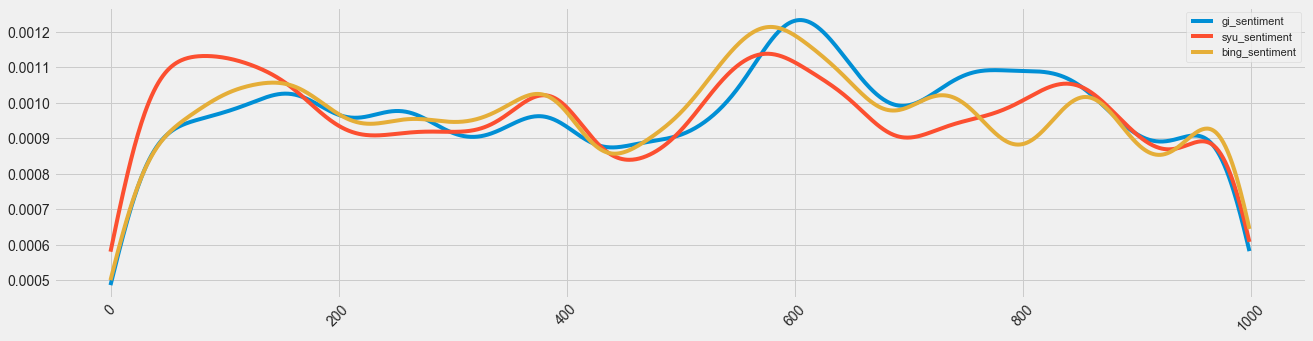

In [104]:
plot_sentiment('gi_sentiment', type='kde')
plot_sentiment('syu_sentiment', type='kde')
plot_sentiment('bing_sentiment', type='kde')